1. The Model
=================


In [1]:
import errno
import json
import os

import cv2
%pylab inline

import pandas as pd
import scipy.misc
from scipy.ndimage import rotate
from scipy.stats import bernoulli
from scipy import signal

import glob
import math
import matplotlib.gridspec as gridspec
import random
from scipy import ndimage
import skimage

Populating the interactive namespace from numpy and matplotlib


In [2]:
DRIVING_LOG_FILE = './data/driving_log.csv'
IMG_PATH = './data/'
STEERING_COEFFICIENT = 0.229

In [3]:
data = pd.read_csv('data/driving_log.csv')
data.head()

,center,left,right,steering,throttle,brake,speed
0,IMG\center_2016_12_01_13_30_48_287.jpg,IMG\left_2016_12_01_13_30_48_287.jpg,IMG\right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG\center_2016_12_01_13_30_48_404.jpg,IMG\left_2016_12_01_13_30_48_404.jpg,IMG\right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG\center_2016_12_01_13_31_12_937.jpg,IMG\left_2016_12_01_13_31_12_937.jpg,IMG\right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG\center_2016_12_01_13_31_13_037.jpg,IMG\left_2016_12_01_13_31_13_037.jpg,IMG\right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG\center_2016_12_01_13_31_13_177.jpg,IMG\left_2016_12_01_13_31_13_177.jpg,IMG\right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [4]:
a = data.iloc[12]['center'].strip()
steer = data.iloc[12]['steering'] 
steer

0.0

Image Preprocessing:
==============================================

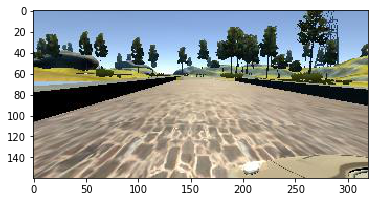

In [5]:
test_image = plt.imread('data\IMG\left_2016_12_01_13_30_48_287.jpg')
plt.imshow(test_image)

## Helper Function For Cropping image.


In [6]:
def crop(image, top_percent, bottom_percent):
    """
    Function crops an image according to the given parameters.
    
    Args:
    - Image: source image
    - top_percent: The percentage of the original image will be croppped from the
                    top of the image.
    - bottom_percent: The percentage of the original image will be cropped from the 
                      bottom of the image
                      
    Return:
    - Cropped image
    
    """
    
    assert 0 <= top_percent < 0.5, 'top percent should be between 0.0 and 0.5'
    assert 0 <= bottom_percent < 0.5, 'top_percent should be between 0.0 and 0.5'
    
    top = int(np.ceil(image.shape[0] * top_percent))
    bottom = image.shape[0] - int(np.ceil(image.shape[0] * bottom_percent))
    
    return image[top:bottom, :]

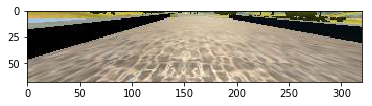

In [7]:
test_image_cropped = crop(test_image,0.37, 0.2)
plt.imshow(test_image_cropped)

## Helper function for Resizing image.

In [8]:
def resize(image, new_dim):
    """
    Resize a given image according to the new dimension
    Args:
    - image: source image
    - new_dim: A tuple which represents the resize dimension
    
    Return:
    - Resized image
    """
   
    return scipy.misc.imresize(image, new_dim)


In [9]:
print('Original Dimension', test_image.shape)
new_image = resize(test_image, (64, 64))
print('Resized Image Dimensions', new_image.shape)

Original Dimension (160, 320, 3)
Resized Image Dimensions (64, 64, 3)


## Helper function for Random flipping of image

In [10]:
def random_flip(image, steering_angle, flipping_prob=0.5):
    """
    Based on a random coin tossing, the image is flipped.
    If flipping is applied, the steering angle is negated.
    
    Args:
    - image: source image
    - steering_angle: Original steering angle
    
    Return:
    - Both flipped image and new steering angle
    """
    
    head = bernoulli.rvs(flipping_prob)
    
    if head:
        return np.flipr(image), -1 * steering_angle
    else:
        return image, steering_angle

In [11]:
a = data.iloc[0]['center'].strip()
steer = data.iloc[0]['steering'] 
a

'IMG\\center_2016_12_01_13_30_48_287.jpg'

In [12]:
def random_gamma(image):
    """
    Random gamma correction is used as an alternative method changing
    the brightness of training images.
    
    Args:
    - image: source image
    
    Return:
    - New image generated by applying gamma correction to the source image 
    
    """
    
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([(( i / 255.0) ** inv_gamma) * 255
                     for i in np.arange(0,256)]).astype("uint8")
    
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


In [13]:
def random_shear(image, steering_angle, shear_range=200):
    """
    Args:
     - image: source image on which the shear operation will be applied
     - steering_angle: the steering angle of the image
     - shear_range: random shear between [-shear_range, shear_range+1]
        will be applied
        
    Return:
     - The image generated by applying random shear on the source image
     
    """
    rows, cols, channels = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols/2 + dx, rows/2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx /( rows / 2) *360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering
    
    return image, steering_angle

In [14]:
def random_rotation(image, steering_angle, rotation_amount=15):
    """
    Args:
     - Image
     - steering_angle
     - rotation_amount
     
    Return:
     - rotated image
     
    """
    
    angle = np.random.uniform(-rotation_amount, rotation_amount + 1)
    rad = (np.pi / 180.0) * angle
    return rotate(image, angle, reshape=False), steering_angle + (-1) * rad


In [15]:
def min_max(data, a=-0.5, b=0.5):
    """
    Args:
     - data:
     - a:
     - b:
     
    Return:
    
    
    """
    
    data_max = np.max(data)
    data_min = np.min(data)
    
    return a + (b-a) * ((data - data_min) / (data_max - data_min))

In [16]:
def generate_new_image(image, steering_angle, top_crop_percent=0.35,
                      bottom_crop_percent = 0.1, resize_dim=(64, 64),
                      do_shear_prob=0.9):
    
    """
    Args:
     - Image:
     - steering_angle:
     - top_crop_percent:
     - bottom_crop_percent:
     - resize_dim:
     - do_shear_prob:
     - shear_range:
     
    Return:
        
    """
    
    head = bernoulli.rvs(do_shear_prob)
    if head == 1:
        image, steering_angle = random_shear(image, steering_angle)
        
    image = crop(image, top_crop_percent, bottom_crop_percent)
    
    image, steering_angle = random_flip(image, steering_angle)
    
    image = random_gamma(image)
    
    image = resize(image, resize_dim)
    
    return image, steering_angle

In [17]:
def get_next_image_files(batch_size=64):
    """
    At training time, we are picking images for training we randomly pick one 
    of the left, center, and right images and its steering angle.
    
    Args:
     - batch_size: size of the image batch
     
    Return:
     - A list of selected (image files names, respective steering angles)
    """
    
    data = pd.read_csv('data/driving_log.csv')
    num_of_images = len(data)
    rnd_indices = np.random.randint(0, num_of_images, batch_size)
    
    image_files_and_angles = []
    for index in rnd_indices:
        rnd_image = np.random.randint(0, 3)
        if rnd_image == 0:
            img =  data.iloc[index]['left'].strip()
            angle = data.iloc[index]['steering'] + 0.229
            image_files_and_angles.append((img, angle))
            
        elif rnd_image == 1:
            img = data.iloc[index]['center'].strip()
            angle = data.iloc[index]['steering']
            image_files_and_angles.append((img, angle))
            
        else:
            img = data.iloc[index]['right'].strip()
            angle = data.iloc[index]['steering'] - 0.229
            image_files_and_angles.append((img, angle))
            
    return image_files_and_angles

In [18]:
def generate_next_batch(batch_size=64):
    """
    Args:
     - batch_size: Number of training images in a single batch
     
    Return :
     - A tuple of features and steering angles as two Numpy arrays
    """
    
    while True:
        X_batch = []
        y_batch = []
        
        images = get_next_image_files(batch_size)
        
        for img_file, angle in images:
            raw_image = plt.imread('data' + img_file)
            raw_angle = angle
            new_image, new_angle = generate_new_image(raw_image, raw_angle)
            
            X_batch.append(new_image)
            y_batch.append(new_angle)
            
        assert len(X_batch) == batch_size, 'len(X_batch) == batch_size should\
                                            True'
        
        yield np.array(X_batch), np.array(y_batch)

In [19]:
def save_model(model, model_name='model.json', weights_name='model.h5'):
    """
    Save the model into the hard disk
    :param model:
        Keras model to be saved
    :param model_name:
        The name of the model file
    :param weights_name:
        The name of the weight file
    :return:
        None
    """
    silent_delete(model_name)
    silent_delete(weights_name)

    json_string = model.to_json()
    with open(model_name, 'w') as outfile:
        json.dump(json_string, outfile)

    model.save_weights(weights_name)

In [20]:
def silent_delete(file):
    """
    This method delete the given file from the file system if it is available
    Source: http://stackoverflow.com/questions/10840533/most-pythonic-way-to-delete-a-file-which-may-not-exist
    :param file:
        File to be deleted
    :return:
        None
    """
    try:
        os.remove(file)

    except OSError as error:
        if error.errno != errno.ENOENT:
            raise

In [43]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Lambda, Activation, MaxPooling2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras.models import model_from_json
import json

In [44]:
tf.python.control_flow_ops = tf

nummber_of_epochs = 8
number_of_samples_per_epoch = 20032
number_of_validation_samples = 6400
learning_rate = 1e-4
activation_relu = 'relu'

model = Sequential()

model.add(Lambda(lambda x: x /127.5 - 1.0, input_shape=(64, 64, 3)))

In [46]:

nb_filter1 = 32
nb_filter2 = 64
nb_filter3 = 128
# size of pooling area for max pooling
pool_size = (2, 2)
pool_strides = (1,1)
# convolution kernel size
kernel_size = (3, 3)
# number of hidden units in the first fully connected layer
nb_fc1=128
nb_fc2=128


model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(64,64,3)))
model.add(Convolution2D(32, 3,3 ,border_mode='same', subsample=(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(1,1)))
model.add(Convolution2D(64, 3,3 ,border_mode='same',subsample=(2,2)))
model.add(Activation('relu',name='relu2'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(128, 3,3,border_mode='same',subsample=(1,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(1))
model.summary()


adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

restart= False
if os.path.isfile(model_json) and restart:
    try:
        with open(model_json) as jfile:
            model = model_from_json(json.load(jfile))
            model.load_weights(model_weights)    
        print('loading trained model ...')
    except Exception as e:
        print('Unable to load model', model_name, ':', e)
        raise    

model.compile(optimizer=adam, loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_7 (Lambda)                (None, 64, 64, 3)     0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
convolution2d_25 (Convolution2D) (None, 32, 32, 32)    896         lambda_7[0][0]                   
____________________________________________________________________________________________________
activation_21 (Activation)       (None, 32, 32, 32)    0           convolution2d_25[0][0]           
____________________________________________________________________________________________________
maxpooling2d_18 (MaxPooling2D)   (None, 31, 31, 32)    0           activation_21[0][0]              
___________________________________________________________________________________________

NameError: name 'model_json' is not defined

In [47]:
nb_epoch=1
history = model.fit_generator(train_generator,
                    samples_per_epoch=20000, nb_epoch=nb_epoch,
                    verbose=1)

json_string = model.to_json()
with open(model_json, 'w') as outfile:
    json.dump(json_string, outfile)
model.save_weights(model_weights)

NameError: name 'train_generator' is not defined